In [1]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import nltk

In [2]:
with open("\\Users\\Mahesa\\Documents\\INI KULIAH BUKAN MAIN MAIN\\Competition\\GEMASTIK 2022\\Data Mining\\src\data\\newsdatasetshuffle_4000.csv", 'r') as csvfile:
    print(f"Header:\n\n{csvfile.readline()}")
    print(f"Data point:\n\n{csvfile.readline()}")

Header:

,source,url,title,timestamp,label

Data point:

0,detik,https://finance.detik.com/berita-ekonomi-bisnis/d-5543655/stok-gula-aman-pabrik-makanan-siap-ngebut-lagi,"Stok Gula Aman, Pabrik Makanan Siap Ngebut Lagi",23 Apr 2021 13:01 WIB,industri



In [3]:
NUM_WORDS = 10000
EMBEDDING_DIM = 32
MAXLEN = 40
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .85

In [4]:
def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[5])
            sentence = row[3]
            sentences.append(sentence)

    return sentences, labels

In [5]:
sentences, labels = parse_data_from_file("newsdatasetshuffle_4000.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 4000 sentences in the dataset.

There are 4000 labels in the dataset.

The first 5 labels are ['industri', 'perang', 'properti', 'teknologi', 'perang']


In [6]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')
len(stopwords_ind)

758

In [7]:
def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [8]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [9]:
def text_preprocessing_process(text):
    text = remove_stop_words(text)
    text = stemming(text)
    return text

In [10]:
sentences_nostopword = []
for i in sentences:
    sentences_nostopword.append(text_preprocessing_process(i))
sentences = sentences_nostopword
print(sentences)

['stok gula aman pabrik makan siap ngebut lagi', 'cuplik nestapa ethiopia negara miskin jebak perang saudara', 'ssstt ini rahasia tajir jual-beli properti', 'menteri era sby yakin nadiem makarim maju didik ri', 'dewan kolonel vs dewan kopral perang dukung puan ganjar maju pilpres 2024', 'prinsipal chery mau bangun pusat litbang indonesia', 'ini cara pakai teknologi ukur celana otomatis kasual', 'mantan menkeu gubernur bi bicara soal resesi ri bisa kena', 'tan hati makan mi besok harga naik 3 kali lipat', 'ada jurang vokasi industri usaha mau laku ini', 'anak lansia lviv ukraina latih guna senjata', 'jokowi sebut strategi gas-rem saat pandemi sukses pulih industri', '5 profesi bisa laku rumah mahasiswa pilih mana', 'kata sri mulyani minyak jadi mahal gara-gara jadi alat perang', 'survei bi harga properti lambat kuartal i 2021', 'ada perintah atur dalam kencang alih fungsi lahan', 'industri film indonesia bangkit pascapandemi fajar nugros bilang begini', 'ekonomi ri ramal kalah china 202

In [11]:
def train_val_split(sentences, labels, training_split):
    
    train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(sentences, labels, 
                                                                                              test_size=1-training_split,
                                                                                              random_state=10)
    validation_sentences, test_sentences, validation_labels, test_labels = train_test_split(validation_sentences,
                                                                                            validation_labels,
                                                                                            test_size=0.5,
                                                                                            random_state=10)
    
    return train_sentences, validation_sentences, test_sentences, train_labels, validation_labels, test_labels

In [12]:
train_sentences, val_sentences, test_sentences, train_labels, val_labels, test_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.\n")
print(f"There are {len(test_sentences)} sentences for test.\n")
print(f"There are {len(test_labels)} labels for test.")

There are 3399 sentences for training.

There are 3399 labels for training.

There are 300 sentences for validation.

There are 300 labels for validation.

There are 301 sentences for test.

There are 301 labels for test.


In [13]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [14]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 4993 words

<OOV> token included in vocabulary


In [15]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    
    ### END CODE HERE
    
    return padded_sequences

In [16]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)
test_padded_seq = seq_and_pad(test_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (3399, 40)

Padded validation sequences have shape: (300, 40)


In [17]:
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels
    
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    
    Returns:
        label_seq_np (array of int): tokenized labels
    """
    ### START CODE HERE
    
    # Instantiate the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    substracted_label_seq=[]
    for i in label_seq:
        for j in i:
            substracted_label_seq.append([j-1])
    
    label_seq_np = np.array(substracted_label_seq)
    
    ### END CODE HERE
    
    return label_seq_np

In [18]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)
test_label_seq = tokenize_labels(labels, test_labels)

print(f"First 10 labels of the training set should look like this:\n{train_label_seq[:10]}\n")
print(f"First 10 labels of the validation set should look like this:\n{val_label_seq[:10]}\n")
print(f"First 10 labels of the test set should look like this:\n{test_label_seq[:10]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")
print(f"Tokenized labels of the test set have shape: {test_label_seq.shape}\n")

First 10 labels of the training set should look like this:
[[4]
 [3]
 [2]
 [2]
 [1]
 [3]
 [4]
 [1]
 [0]
 [1]]

First 10 labels of the validation set should look like this:
[[1]
 [4]
 [3]
 [2]
 [0]
 [0]
 [4]
 [1]
 [3]
 [3]]

First 10 labels of the test set should look like this:
[[1]
 [2]
 [2]
 [1]
 [1]
 [2]
 [0]
 [4]
 [4]
 [0]]

Tokenized labels of the training set have shape: (3399, 1)

Tokenized labels of the validation set have shape: (300, 1)

Tokenized labels of the test set have shape: (301, 1)



In [19]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text classifier model
    """
    
    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, 32, input_length=40),
        tf.keras.layers.Conv1D(128, 10, activation='relu'),
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.LSTM(256),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=7e-5),
                  metrics=['accuracy']) 

    ### END CODE HERE

    return model

In [20]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=5, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/5
107/107 [==============================] - 15s 118ms/step - loss: 1.6096 - accuracy: 0.2030 - val_loss: 1.6093 - val_accuracy: 0.2133
Epoch 2/5
107/107 [==============================] - 12s 108ms/step - loss: 1.6094 - accuracy: 0.2018 - val_loss: 1.6088 - val_accuracy: 0.2267
Epoch 3/5
107/107 [==============================] - 12s 108ms/step - loss: 1.3797 - accuracy: 0.3263 - val_loss: 1.2843 - val_accuracy: 0.4200
Epoch 4/5
107/107 [==============================] - 12s 112ms/step - loss: 1.1419 - accuracy: 0.4754 - val_loss: 1.1680 - val_accuracy: 0.5333
Epoch 5/5
107/107 [==============================] - 12s 109ms/step - loss: 0.9912 - accuracy: 0.5705 - val_loss: 1.1102 - val_accuracy: 0.5800


In [2]:
predict_y = model.predict(test_padded_seq)
print(predict_y)

NameError: name 'model' is not defined

In [22]:
le = LabelEncoder()
labels = le.fit_transform(labels)

In [23]:

# print((test_label_seq))
y_predict = []
for i in predict_y:
    y_predict.append(tf.argmax(i))
y = classification_report(test_label_seq,y_predict, target_names=le.classes_)
# print(y_predict)



# test_label_seq

In [24]:
print(y)

              precision    recall  f1-score   support

    industri       0.68      0.30      0.42        50
pemerintahan       0.82      0.63      0.71        65
      perang       0.58      0.60      0.59        58
    properti       0.35      0.62      0.45        56
   teknologi       0.51      0.50      0.51        72

    accuracy                           0.54       301
   macro avg       0.59      0.53      0.54       301
weighted avg       0.59      0.54      0.54       301



[Text(0, 0.5, 'industri'),
 Text(0, 1.5, 'pemerintahan'),
 Text(0, 2.5, 'perang'),
 Text(0, 3.5, 'properti'),
 Text(0, 4.5, 'teknologi')]

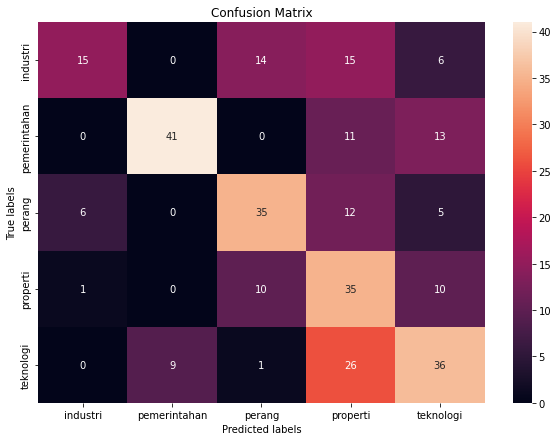

In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(confusion_matrix(test_label_seq, y_predict),annot=True,ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(le.classes_)
ax.yaxis.set_ticklabels(le.classes_)

In [1]:
model.save_model('model/cnn_lstm-model.h5')

NameError: name 'model' is not defined